In [411]:
# importing modules used in this project
import pandas as pd
import numpy as np
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import tkinter as tk
import os
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
#local module
import dataproject

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None
plt.style.use('seaborn-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Change in level of education and distribution between men and women.

We've chosen to import data from www.statistikbanken.dk/UDDAKT10.  
It shows the level of education based on sex, education, year, and age.

With this we can analyze how each level of education the distribution between men and women has developed over the time period.

First thing we want to do is make the data easier to read.  
By creating an interactive table we can choose sex, education, year, age and see the education activity for the specific variables.

In [413]:
#Open the data file and taking a look at it
Data = 'Data.xlsx'
pd.read_excel(Data).head(5)

,"Uddannelsesaktivitet efter status, bopælsområde, køn, uddannelse, alder og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Enhed: antal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
2,Fuldført,Hele landet,Mænd og kvinder i alt,H10 Grundskole,Alder i alt,93865.0,95634.0,94320.0,100198.0,100715.0,102939.0,105233.0,106509.0,104984.0,103470.0,102982.0,103751.0,100831.0,100202.0,101043.0
3,NaN,NaN,NaN,NaN,-5 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,29.0
4,NaN,NaN,NaN,NaN,6 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,81.0


In [415]:
#Removing the first two rows as they are empty and not needed for this project.
df = pd.read_excel(Data, skiprows=2)


#Removing first 2 columns
drop_these = ['Unnamed: 0', 'Unnamed: 1']
df.drop(drop_these, axis=1, inplace=True) # axis = 1 -> columns, inplace=True -> changed, no copy made

In [ ]:
#Currently the first 3 coloumns have to title.
#Renaming the columns
df.rename(columns = {'Unnamed: 2':'sex'}, inplace=True)
df.rename(columns = {'Unnamed: 3':'education'}, inplace=True)
df.rename(columns = {'Unnamed: 4':'age'}, inplace=True)

In [418]:
#we also want to rename the categories containing æ, just to be sure, and to make it easier to understand.
#find index of sex and giving it a variable.
total = df.loc[df["sex"]=="Mænd og kvinder i alt"].index
male = df.loc[df["sex"]=="Mænd"].index
female = df.loc[df["sex"]=="Kvinder"].index
#renaming the "Mænd og kvinder i alt" and so on to  total, male, and female
df["sex"][total] = "total"
df["sex"][male] = "male"
df["sex"][female] = "female"

In [420]:
#The way the data is structured, only the first cell in a new subcategory has a value name
#We want to change it so every cell has the equivilant subcategory name.

#rename nan in sex to floats.
for i in range(0,len(df)):
    if type(df["sex"][i]) == str:
        x = df["sex"][i]
    else:
        df["sex"][i] = x

#rename nan in Education to floats
for i in range(0,len(df)):
    if type(df["education"][i]) == str:
        x = df["education"][i]
    else:
        df["education"][i] = x

In [422]:
#Formatting the dataframe to long so it's easier to work with in the interactive table.
df_long = pd.melt(df,id_vars=["sex","education","age"], var_name="year",value_name="uddannelsesaktivitet")

In [424]:
#Now that the dataframe is formatted for use in the table we can start creating the table.

ALL = 'ALL' # eg. the ALL for sex will include male female and male+female (total)
# Generating dropdown menues using the optoins from the 
# Using dataproject.unique_sorted_values_plus_all from the module which creates a unique option for each subcategory.
dropdown_year = widgets.Dropdown(options=dataproject.unique_sorted_values_plus_all(df_long.year))
dropdown_age = widgets.Dropdown(options=dataproject.unique_sorted_values_plus_all(df_long.age))
dropdown_sex = widgets.Dropdown(options=dataproject.unique_sorted_values_plus_all(df_long.sex))
dropdown_education = widgets.Dropdown(options=dataproject.unique_sorted_values_plus_all(df_long.education))

#Defining outputs
output = widgets.Output()
plot_output = widgets.Output()

In [426]:
# Defining the function to later observe.
# these are defined in the .ipynb becuase we do not know how to pass the variables through .observe in the next cell.

# takes all the dropdowns and dataframe for the function "filters" except change instead of year so the .observe on year will look for changes in the year dropdown widget.
def dropdown_year_eventhandler(change, dropdown_age = dropdown_age, dropdown_sex = dropdown_sex, dropdown_education = dropdown_education, df_long = df_long, output = output, plot_output = plot_output):
    dataproject.filters(change.new, dropdown_age.value, dropdown_sex.value, dropdown_education.value, df_long, output, plot_output)

#same as year, but with age and so on.
def dropdown_age_eventhandler(change, dropdown_year = dropdown_year, dropdown_sex = dropdown_sex, dropdown_education = dropdown_education, df_long = df_long, output = output, plot_output = plot_output):
    dataproject.filters(dropdown_year.value, change.new, dropdown_sex.value, dropdown_education.value, df_long, output, plot_output)

def dropdown_sex_eventhandler(change, dropdown_year = dropdown_year, dropdown_age = dropdown_age, dropdown_education = dropdown_education, df_long = df_long, output = output, plot_output = plot_output):
    dataproject.filters(dropdown_year.value, dropdown_age.value, change.new, dropdown_education.value, df_long, output, plot_output)

def dropdown_education_eventhandler(change, dropdown_year = dropdown_year, dropdown_age = dropdown_age, dropdown_sex = dropdown_sex, df_long = df_long, output = output, plot_output = plot_output):
    dataproject.filters(dropdown_year.value, dropdown_age.value, dropdown_sex.value, change.new, df_long, output, plot_output)


In [428]:
#Observe changes in the dropdown.
dropdown_year.observe(
dropdown_year_eventhandler, names='value')
dropdown_age.observe(
dropdown_age_eventhandler, names='value')
dropdown_sex.observe(
dropdown_sex_eventhandler, names='value')
dropdown_education.observe(
dropdown_education_eventhandler, names='value')

In [430]:
#Display dropdown menus
# 
display(dropdown_year)
display(dropdown_age)
display(dropdown_sex)
display(dropdown_education)

Dropdown(options=('ALL', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015…

Dropdown(options=('ALL', '-5 år', '10 år', '11 år', '12 år', '13 år', '14 år', '15 år', '16 år', '17 år', '18 …

Dropdown(options=('ALL', 'female', 'male', 'total'), value='ALL')

Dropdown(options=('ALL', 'H10 Grundskole', 'H15 Forberedende uddannelser', 'H20 Gymnasiale uddannelser', 'H29 …

In [432]:
#Display Table
display(output)
#Display graph
#The graph does not work if there are 1 or less total data points, some options have NaN and will break the graph.
#display(plot_output) # ommitted because it looks ugly and doesn't really make any sence.

Output()

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            397, 398, 399, 400, 401, 402, 403, 404, 405, 406],
           dtype='int64', length=407)


In [434]:
df_data1 = pd.read_excel(r'C:\Users\MathiasUdsen\Desktop\Uni\4. Semester\Program\Opgave 2\Data0.xlsx', skiprows=2, usecols = 'D : T')
display(df_data1)

# Dropping missing data 
df_data1.dropna()


,Unnamed: 3,Unnamed: 4,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Grundskole,Alder i alt,93865.0,95634.0,94320.0,100198.0,100715.0,102939.0,105233.0,106509.0,104984.0,103470.0,102982.0,103751.0,100831.0,100202.0,101043.0
1,Grundskole,-5 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,29.0
2,Grundskole,6 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,81.0
3,Grundskole,7 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,2.0,3.0
4,Grundskole,8 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0
5,Grundskole,9 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,0.0
6,Grundskole,10 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0
7,Grundskole,11 år,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,6.0,2.0,0.0,4.0,5.0,2.0
8,Grundskole,12 år,0.0,0.0,6.0,11.0,6.0,2.0,1.0,7.0,9.0,6.0,6.0,9.0,9.0,6.0,1.0
9,Grundskole,13 år,33.0,48.0,65.0,99.0,19.0,4.0,13.0,13.0,20.0,26.0,17.0,15.0,13.0,11.0,9.0


,Unnamed: 3,Unnamed: 4,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Grundskole,Alder i alt,93865.0,95634.0,94320.0,100198.0,100715.0,102939.0,105233.0,106509.0,104984.0,103470.0,102982.0,103751.0,100831.0,100202.0,101043.0
1,Grundskole,-5 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,29.0
2,Grundskole,6 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,81.0
3,Grundskole,7 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,2.0,3.0
4,Grundskole,8 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0
5,Grundskole,9 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,0.0
6,Grundskole,10 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0
7,Grundskole,11 år,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,6.0,2.0,0.0,4.0,5.0,2.0
8,Grundskole,12 år,0.0,0.0,6.0,11.0,6.0,2.0,1.0,7.0,9.0,6.0,6.0,9.0,9.0,6.0,1.0
9,Grundskole,13 år,33.0,48.0,65.0,99.0,19.0,4.0,13.0,13.0,20.0,26.0,17.0,15.0,13.0,11.0,9.0


In [437]:
years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]


df_data1.rename(columns = {'Unnamed: 3':'Education'}, inplace=True)

Grundskole = df_data1.loc[df_data1['Education']=='Grundskole']
GU = df_data1.loc[df_data1['Education']=='Gymnasiale uddannelser']
EU = df_data1.loc[df_data1['Education']=='Erhvervsfaglige uddannelser']
KVU = df_data1.loc[df_data1['Education']=='Korte videregående uddannelser']
MVU = df_data1.loc[df_data1['Education']=='Mellemlange videregående uddannelser']
BACH = df_data1.loc[df_data1['Education']=='Bacheloruddannelser']
LVU = df_data1.loc[df_data1['Education']=='Lange videregående uddannelser']
PHD = df_data1.loc[df_data1['Education']=='Ph.d. og forskeruddannelser']

#pd.set_option('display.max_rows', df_data1.shape[0]+1)

df_data1.rename(columns = {'Unnamed: 4':'age'}, inplace=True)

Grundskole

,Education,age,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Grundskole,Alder i alt,93865.0,95634.0,94320.0,100198.0,100715.0,102939.0,105233.0,106509.0,104984.0,103470.0,102982.0,103751.0,100831.0,100202.0,101043.0
1,Grundskole,-5 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,29.0
2,Grundskole,6 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,20.0,81.0
3,Grundskole,7 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,2.0,3.0
4,Grundskole,8 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0
5,Grundskole,9 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,0.0
6,Grundskole,10 år,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0
7,Grundskole,11 år,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,6.0,2.0,0.0,4.0,5.0,2.0
8,Grundskole,12 år,0.0,0.0,6.0,11.0,6.0,2.0,1.0,7.0,9.0,6.0,6.0,9.0,9.0,6.0,1.0
9,Grundskole,13 år,33.0,48.0,65.0,99.0,19.0,4.0,13.0,13.0,20.0,26.0,17.0,15.0,13.0,11.0,9.0


In [490]:
# Grundskole
Grundskole_all = Grundskole.iloc[0:37]
Grundskole_all = Grundskole_all.drop([0])
Grundskole_all = Grundskole_all.drop(columns = ['Education', 'age'])
#display(Grundskole_all)
Grundskole_all_sum = Grundskole_all.sum(axis = 0) 
#display(Grundskole_all_sum)


GU_all = GU.iloc[0:37]
GU_all = GU_all.drop([74])
GU_all = GU_all.drop(columns = ['Education' , 'age'])
GU_all = 
display(GU_all)

#EU_all = 
#KVU_all = 
#MVU_all = 
#BACH_all = 
#LVU_all = 
#PHD_all = 




,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [441]:
data = pd.read_excel (r'Data.xlsx') # import the data
# År
years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

# Total antal

antal_tot_1 = np.array(data.iloc[2,5:20])

#print(antal_tot_1)

# Alder

alder_1 = np.array(data.iloc[3:39,4])

#print(alder_1)


# Antal

i = np.array(range(15))
#print(i)
antal_test =  np.array(data.iloc[3:39,5+i])
antal = antal_test.transpose()
#print(antal)



In [443]:
# mænd
z = np.array([0, 37, 37*2, 37*3 ,37*4, 37*5, 37*6, 37*7, 37*8, 37*9, 37*10])

np.ones(11)

alder_m = np.array(data.iloc[410+z[0]:446+z[0],4])

#print(alder_m)

antal_tot_m = np.array(data.iloc[409+z,5:20])

#print(antal_tot_m)

uddannelse_m = pd.Series(['Grundskole_m','Forberedende uddannelser_m','Gymnasiale uddannelser_m','Erhvervsfaglige grundforløb_m','Erhvervsfaglige uddannelser_m','Adgangsgivende uddannelsesforløb_m','KVU_m','MVU_m','BACH_m','LVU_m','Ph.d. og forskeruddannelser_m'])
uddannelse_k = pd.Series(['Grundskole_k','Forberedende uddannelser_k','Gymnasiale uddannelser_k','Erhvervsfaglige grundforløb_k','Erhvervsfaglige uddannelser_k','Adgangsgivende uddannelsesforløb_k','KVU_k','MVU_k','BACH_k','LVU_k','Ph.d. og forskeruddannelser_k'])


In [445]:
df_m = pd.DataFrame(
    antal_tot_m,
    columns = years,
    index = uddannelse_m
)
#print(df_m)
df_m.drop('Forberedende uddannelser_m', inplace=True)
df_m.drop('Erhvervsfaglige grundforløb_m', inplace=True)

df_m


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Grundskole_m,47223.0,48194.0,47444.0,50593.0,50937.0,51821.0,53191.0,54278.0,53660.0,53121.0,52567.0,53096.0,51632.0,51439.0,51863.0
Gymnasiale uddannelser_m,13641.0,13237.0,13652.0,14053.0,15272.0,16202.0,17528.0,18899.0,20267.0,21001.0,21019.0,21245.0,21019.0,21597.0,21989.0
Erhvervsfaglige uddannelser_m,14502.0,14826.0,15244.0,15514.0,16213.0,17233.0,16796.0,16550.0,15920.0,17337.0,15327.0,16631.0,16037.0,15864.0,14886.0
Adgangsgivende uddannelsesforløb_m,706.0,551.0,578.0,487.0,533.0,740.0,836.0,828.0,890.0,773.0,680.0,639.0,643.0,564.0,418.0
KVU_m,2703.0,2532.0,2798.0,2958.0,2739.0,3122.0,3491.0,3848.0,4300.0,4065.0,4487.0,4920.0,4954.0,4986.0,5178.0
MVU_m,4439.0,4651.0,4540.0,4414.0,4590.0,4430.0,4887.0,5051.0,6227.0,6930.0,7605.0,8065.0,8185.0,8344.0,8260.0
BACH_m,4714.0,4711.0,5369.0,5555.0,5979.0,6187.0,6353.0,6509.0,7291.0,7970.0,8350.0,9232.0,8314.0,8402.0,8310.0
LVU_m,6026.0,6167.0,6491.0,5927.0,6462.0,6319.0,6577.0,6971.0,7288.0,7655.0,8627.0,11694.0,11078.0,10503.0,10348.0
Ph.d. og forskeruddannelser_m,600.0,507.0,635.0,673.0,688.0,794.0,869.0,879.0,1053.0,1150.0,1143.0,1151.0,1159.0,1069.0,0.0


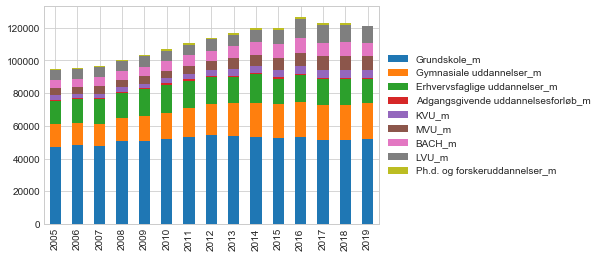

In [447]:

df_m.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()




In [449]:
# Kvinder 
alder_k = np.array(data.iloc[817+z[0]:853+z[0],4])


antal_tot_k = np.array(data.iloc[816+z,5:20])



In [451]:
df_k = pd.DataFrame(
    antal_tot_k,
    columns = years,
    index = uddannelse_k
)
#print(df_k)

# Drop
df_k.drop('Erhvervsfaglige grundforløb_k', inplace=True)
df_k.drop('Forberedende uddannelser_k',inplace=True)

df_k

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Grundskole_k,46642.0,47440.0,46876.0,49605.0,49778.0,51118.0,52042.0,52231.0,51324.0,50349.0,50415.0,50655.0,49199.0,48763.0,49180.0
Gymnasiale uddannelser_k,18804.0,18092.0,18508.0,18751.0,20087.0,20955.0,21966.0,23253.0,24154.0,25163.0,25204.0,25306.0,24836.0,25897.0,26680.0
Erhvervsfaglige uddannelser_k,16848.0,16381.0,16561.0,16693.0,16691.0,15528.0,15752.0,16783.0,16379.0,16563.0,15744.0,16955.0,16071.0,14333.0,11045.0
Adgangsgivende uddannelsesforløb_k,250.0,256.0,280.0,249.0,210.0,207.0,184.0,224.0,250.0,217.0,198.0,175.0,192.0,241.0,191.0
KVU_k,2301.0,2250.0,2647.0,2775.0,2655.0,2807.0,3207.0,3326.0,3635.0,3846.0,4009.0,4450.0,4516.0,4348.0,4458.0
MVU_k,11357.0,10613.0,9995.0,10007.0,10545.0,10348.0,10128.0,9952.0,11599.0,12522.0,13064.0,13417.0,13360.0,13612.0,13735.0
BACH_k,5984.0,5986.0,6548.0,6896.0,7650.0,8390.0,8014.0,8501.0,9435.0,9734.0,10004.0,11106.0,9916.0,10010.0,10202.0
LVU_k,6617.0,6659.0,7330.0,7170.0,7657.0,7480.0,8043.0,8678.0,9386.0,10149.0,11046.0,15162.0,13970.0,13207.0,13414.0
Ph.d. og forskeruddannelser_k,417.0,417.0,441.0,506.0,540.0,664.0,726.0,776.0,869.0,1020.0,1071.0,1078.0,1084.0,1024.0,0.0


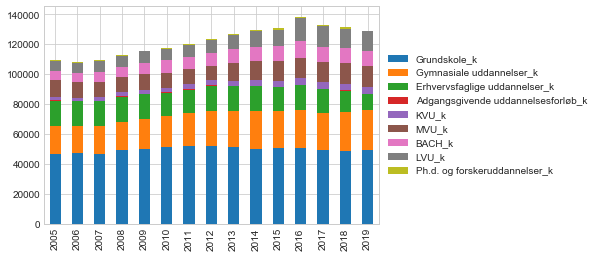

In [453]:
df_k.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

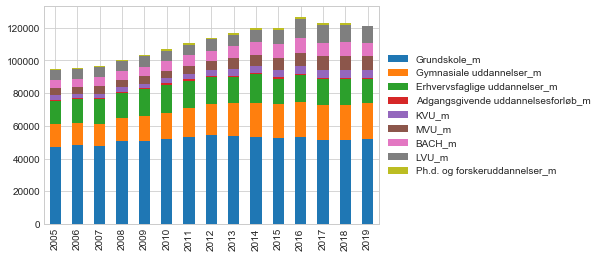

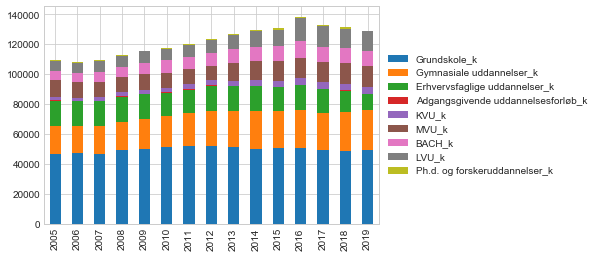

In [455]:
# Appending
df_mk = df_m.append(df_k)

df_mk

df_m.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

df_k.T.plot(kind = 'bar', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()



In [457]:
i = np.array(range(15))
#print(i)
antal_test =  np.array(data.iloc[3:39,5+i])
antal = antal_test.transpose()
#print(antal)


#c = np.array(range(36))

x_1 = np.array(range(36))
x = sorted(x_1,reverse=True)



def v(x ,c = 36):
    return np.array(range(0, c-x))
def w(x):
    return sorted(v(x), reverse=True)
#print(w(0))

#def v:
#    if v>0:
#        return ()
#    if v < 0:
#        return
    


def antal_a_2005(x, i = 0):
    return np.array(data.iloc[3+v(x),5+i])


#def antal_a_2005(v, c = c, i = 0):
#    return np.array(data.iloc[3+c-v,5+i])
